# Lab 7: Optimization and Regularization 



The goal of this lab is to learn how to apply different regularization and optimization strategies in PyTorch using MNIST data.

Here is a list of the techniques we've covered in class
- Optimization
    - SGD
    - SGD (with momentum)
    - Nesterov momentum
    - AdaGrad
    - RMSProp
    - Adam
- Some regularization
    - Dropout
    - Batch normalization

 

## Problem Setup

In [1]:
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize necessary parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(717)

seed = 345
batch_size = {'train': 64,
              'val': 1000}
input_size = 28 * 28
output_size = 10
n_feature = 3
optim_results = {}

In [3]:
# Data Loader
trainset = datasets.MNIST('data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
testset = datasets.MNIST('data', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

mnist_datasets = {'train': trainset, 
            'val': testset}
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(mnist_datasets[x], batch_size=batch_size[x], shuffle=True)
              for x in ['train', 'val']}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



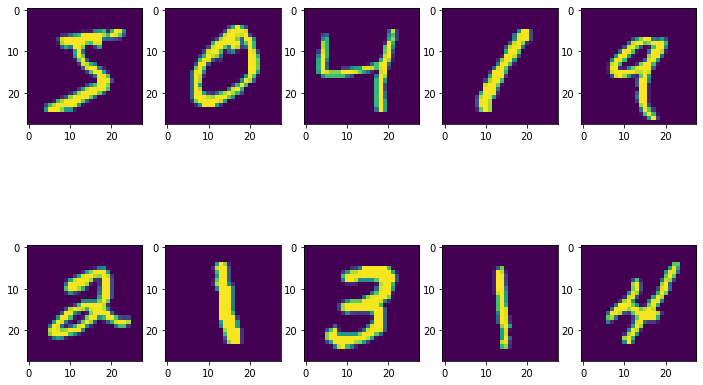

In [4]:
## show some images
plt.figure(figsize = (12, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = dataloaders['train'].dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [5]:
def train_model(model, optimizer, num_epochs=1, verbose = True, print_every = 100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
                
                if verbose and batch_idx % print_every == 0:
                    print('Train set | epoch: {:3d} | {:6d}/{:6d} batches | Loss: {:6.4f}'.format(
                        epoch, batch_idx * len(inputs), len(dataloaders[phase].dataset), loss.item()))
                    loss_dict[phase].append(running_loss/((batch_idx + 1) * len(inputs)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict

def populate_result(dictionary, method, train_loss, val_loss):
    dictionary[method] = {}
    dictionary[method]['train_loss'] = np.array(train_loss)
    dictionary[method]['val_loss'] = np.array(val_loss)
    
def plot_loss(result, loss='train_loss', ylim=None):
    plt.plot(result['Baseline'][loss], label='Baseline')
    for k in result.keys():
        if k != 'Baseline':
            plt.plot(result[k][loss], label=k)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_best_loss(result, loss='val_loss'):
    labels = ['Baseline']
    acc = [np.max(result['Baseline'][loss])]
    for k in result.keys():
        if k != 'Baseline':
            labels.append(k)
            acc.append(np.max(result[k][loss]))

    x = np.arange(len(labels))
    plt.barh(x, acc)
    plt.yticks(x, labels)
    plt.xlabel('Loss')
    plt.show()

### Baseline method

We will later show how different optimization and regularization techniques can improve baseline model performance. But first,
1. What's our baseline model architecture?
2. What's the optimization method used to train the baseline model?
3. How does this optimization method update its parameters.
$$\theta_{t+1} = \theta_{t} - \eta \nabla J(\theta_{t})$$
where $\eta$ denotes the learning rate

In [6]:
class Baseline(nn.Module):
    def __init__(self, n_feature, output_size):
        super(Baseline, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [7]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.2738
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 2.1942
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 1.2512
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.6579
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.5887
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3759
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.4277
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.4009
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.4349
train Loss: 1.0557 Acc: 0.6520
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.3390
val Loss: 0.3611 Acc: 0.8949

Training complete in 0m 26s
Best val Acc: 0.894900


## Fancier Optimization

https://pytorch.org/docs/stable/optim.html

### SGD with momentum
1. How does SGD with momentum update its parameters?
$$v_{t+1} = \rho v_{t} + \nabla J(\theta_{t})$$
$$\theta_{t+1} = \theta_{t} - \eta v_{t+1}$$
where $v$ and $\rho$ denote velocity and momentum, respectively.
2. Check out the documentation for SGD in PyTorch and complete the code below (Set momentum=0.5). 

In [8]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'SGD_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.2016
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.8078
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.4479
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.5111
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4338
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3512
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3868
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3420
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2814
train Loss: 0.7258 Acc: 0.7628
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2514
val Loss: 0.2660 Acc: 0.9202

Training complete in 0m 26s
Best val Acc: 0.920200


### Nesterov momentum

Make a minor change in the above code to apply Nesterov momentum (Set momentum=0.5). 

In [9]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5, nesterov=True)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Nesterov_momentum', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 2.1984
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.8503
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.4673
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.4911
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.4254
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.3275
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.3919
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3366
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2827
train Loss: 0.7238 Acc: 0.7623
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2510
val Loss: 0.2654 Acc: 0.9190

Training complete in 0m 26s
Best val Acc: 0.919000


### AdaGrad

In [10]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adagrad(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adagrad', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.5764
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.5498
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.3729
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.4958
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.3811
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2752
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.2847
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.3045
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.2805
train Loss: 0.4108 Acc: 0.8735
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.2688
val Loss: 0.2727 Acc: 0.9203

Training complete in 0m 27s
Best val Acc: 0.920300


### RMSprop

In [11]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.RMSprop(model.parameters(),lr=0.01, alpha=0.9)
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'RMSprop', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.5165
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.2999
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.2864
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.3417
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.3683
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.1829
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.1320
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.1597
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.1581
train Loss: 0.3351 Acc: 0.8923
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.3722
val Loss: 0.3028 Acc: 0.9108

Training complete in 0m 28s
Best val Acc: 0.910800


### Adam

In [12]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01, betas=(0.9, 0.99))
model, loss_dict = train_model(model, optimizer)
populate_result(optim_results, 'Adam', loss_dict['train'], loss_dict['val'])

Epoch 0/0
----------
Train set | epoch:   0 |      0/ 60000 batches | Loss: 2.3086
Train set | epoch:   0 |   6400/ 60000 batches | Loss: 0.3224
Train set | epoch:   0 |  12800/ 60000 batches | Loss: 0.4379
Train set | epoch:   0 |  19200/ 60000 batches | Loss: 0.1357
Train set | epoch:   0 |  25600/ 60000 batches | Loss: 0.2364
Train set | epoch:   0 |  32000/ 60000 batches | Loss: 0.2357
Train set | epoch:   0 |  38400/ 60000 batches | Loss: 0.2735
Train set | epoch:   0 |  44800/ 60000 batches | Loss: 0.0663
Train set | epoch:   0 |  51200/ 60000 batches | Loss: 0.1503
Train set | epoch:   0 |  57600/ 60000 batches | Loss: 0.1015
train Loss: 0.2715 Acc: 0.9139
Train set | epoch:   0 |      0/ 10000 batches | Loss: 0.1894
val Loss: 0.1636 Acc: 0.9525

Training complete in 0m 27s
Best val Acc: 0.952500


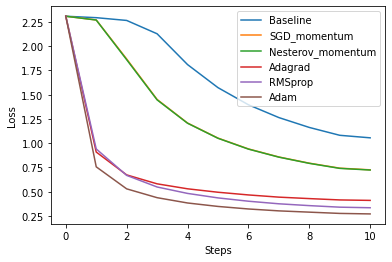

In [13]:
# Plot optimization methods training results
plot_loss(optim_results)

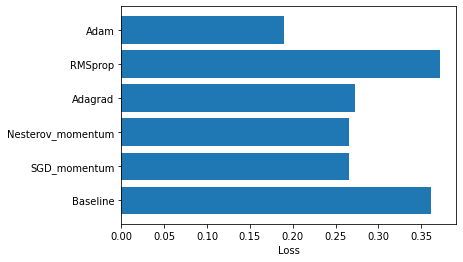

In [14]:
# Plot optimization methods validation results
plot_best_loss(optim_results)

## Regularization

https://pytorch.org/docs/stable/nn.html

In [15]:
# In order to see effects of regularization on validation set, we need to make some slight modification

## Smaller training set
mnist_datasets['train'].data = mnist_datasets['train'].data[:600]
dataset_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}
dataloaders['train'] = torch.utils.data.DataLoader(mnist_datasets['train'], 
                                                   batch_size=batch_size['train'], shuffle=True)

## Longer training epochs
train_epochs = 25
verbose = False
reg_results = {}

### Baseline model

In [16]:
torch.manual_seed(seed)
model = Baseline(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Baseline', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 1.9928 Acc: 0.3383
val Loss: 1.2420 Acc: 0.5742

Epoch 1/24
----------
train Loss: 0.9415 Acc: 0.6767
val Loss: 0.9017 Acc: 0.6950

Epoch 2/24
----------
train Loss: 0.6352 Acc: 0.8100
val Loss: 0.6481 Acc: 0.7816

Epoch 3/24
----------
train Loss: 0.4278 Acc: 0.8667
val Loss: 0.5225 Acc: 0.8363

Epoch 4/24
----------
train Loss: 0.3029 Acc: 0.9100
val Loss: 0.5730 Acc: 0.8267

Epoch 5/24
----------
train Loss: 0.2385 Acc: 0.9133
val Loss: 0.4542 Acc: 0.8563

Epoch 6/24
----------
train Loss: 0.1826 Acc: 0.9433
val Loss: 0.4739 Acc: 0.8637

Epoch 7/24
----------
train Loss: 0.1552 Acc: 0.9500
val Loss: 0.5104 Acc: 0.8498

Epoch 8/24
----------
train Loss: 0.1131 Acc: 0.9733
val Loss: 0.4862 Acc: 0.8730

Epoch 9/24
----------
train Loss: 0.0805 Acc: 0.9700
val Loss: 0.4898 Acc: 0.8788

Epoch 10/24
----------
train Loss: 0.1116 Acc: 0.9583
val Loss: 0.5275 Acc: 0.8713

Epoch 11/24
----------
train Loss: 0.0693 Acc: 0.9767
val Loss: 0.5239 Acc: 0.8663

Ep

### L1/L2 regularization

L2 regularization is included in most optimizers in PyTorch and can be controlled with the __weight_decay__ parameter.
For L1 regularization, check out this post: https://discuss.pytorch.org/t/simple-l2-regularization/139

### Adding Dropout Layer

1. Check out documentations for __nn.Dropout()__. Modify the Baseline model and add dropout layer to the fully connected layers.
2. Optionally, you may also check out documentations for __nn.Dropout2d()__ to learn how to add Dropout layer to convolution layers.

In [17]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, n_feature, output_size, dropout_rate=0.5):
        super(DropoutNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.ReLU(),
                                nn.Dropout(dropout_rate),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [18]:
torch.manual_seed(seed)
model = DropoutNet(input_size, n_feature, output_size, dropout_rate=0.3).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Dropout', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 2.1493 Acc: 0.2617
val Loss: 1.5007 Acc: 0.5894

Epoch 1/24
----------
train Loss: 1.1514 Acc: 0.6117
val Loss: 0.8469 Acc: 0.7067

Epoch 2/24
----------
train Loss: 0.7710 Acc: 0.7533
val Loss: 0.6485 Acc: 0.7872

Epoch 3/24
----------
train Loss: 0.6683 Acc: 0.8017
val Loss: 0.5881 Acc: 0.8156

Epoch 4/24
----------
train Loss: 0.4746 Acc: 0.8567
val Loss: 0.5074 Acc: 0.8374

Epoch 5/24
----------
train Loss: 0.4285 Acc: 0.8617
val Loss: 0.5257 Acc: 0.8438

Epoch 6/24
----------
train Loss: 0.3919 Acc: 0.8817
val Loss: 0.5012 Acc: 0.8403

Epoch 7/24
----------
train Loss: 0.3315 Acc: 0.8900
val Loss: 0.4077 Acc: 0.8755

Epoch 8/24
----------
train Loss: 0.2776 Acc: 0.8983
val Loss: 0.4853 Acc: 0.8628

Epoch 9/24
----------
train Loss: 0.3266 Acc: 0.8867
val Loss: 0.4367 Acc: 0.8661

Epoch 10/24
----------
train Loss: 0.2864 Acc: 0.9033
val Loss: 0.4301 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.2095 Acc: 0.9217
val Loss: 0.3934 Acc: 0.8898

Ep

### Adding Batch Normalization
1. What's the advantage of using batch normalization?
    1. Allow each layer to train relatively more independently
    2. Improve gradient flow through the network
    3. Allows higher learning rate
    4. Reduces strong dependence on initialization
2. Implement batch normalization in __BatchnormNet__. Think about where you may want to insert the batch normalization layer.

In [19]:
class BatchnormNet(nn.Module):
    def __init__(self, n_feature, output_size):
        super(BatchnormNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Sequential(nn.Conv2d(1, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(n_feature, n_feature, kernel_size=5),
                                   nn.BatchNorm2d(n_feature),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(n_feature*4*4, 50),
                                nn.BatchNorm1d(50),
                                nn.ReLU(),
                                nn.Linear(50, 10))


    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc(x)
        return x

In [20]:
torch.manual_seed(seed)
model = BatchnormNet(n_feature, output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
model, loss_dict = train_model(model, optimizer, num_epochs=train_epochs, verbose=verbose)
populate_result(reg_results, 'Batchnorm', loss_dict['train'], loss_dict['val'])

Epoch 0/24
----------
train Loss: 1.6792 Acc: 0.5433
val Loss: 1.4510 Acc: 0.5818

Epoch 1/24
----------
train Loss: 0.7504 Acc: 0.8350
val Loss: 0.8319 Acc: 0.7333

Epoch 2/24
----------
train Loss: 0.3811 Acc: 0.9067
val Loss: 0.6209 Acc: 0.7990

Epoch 3/24
----------
train Loss: 0.2288 Acc: 0.9433
val Loss: 0.4267 Acc: 0.8621

Epoch 4/24
----------
train Loss: 0.1522 Acc: 0.9583
val Loss: 0.3633 Acc: 0.8809

Epoch 5/24
----------
train Loss: 0.1094 Acc: 0.9833
val Loss: 0.4754 Acc: 0.8607

Epoch 6/24
----------
train Loss: 0.0978 Acc: 0.9800
val Loss: 0.4189 Acc: 0.8674

Epoch 7/24
----------
train Loss: 0.0697 Acc: 0.9867
val Loss: 0.4056 Acc: 0.8765

Epoch 8/24
----------
train Loss: 0.0567 Acc: 0.9883
val Loss: 0.4883 Acc: 0.8522

Epoch 9/24
----------
train Loss: 0.0573 Acc: 0.9867
val Loss: 0.3954 Acc: 0.8756

Epoch 10/24
----------
train Loss: 0.0458 Acc: 0.9933
val Loss: 0.3983 Acc: 0.8759

Epoch 11/24
----------
train Loss: 0.0325 Acc: 1.0000
val Loss: 0.4323 Acc: 0.8734

Ep

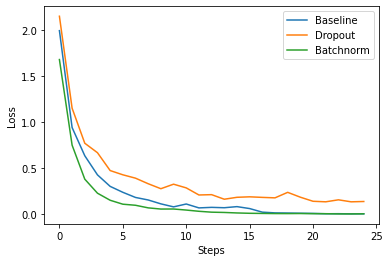

In [21]:
plot_loss(reg_results)

Validation loss using Dropout and Batchnorm start to catch up with the loss of baseline model after baseline model overfits training data.

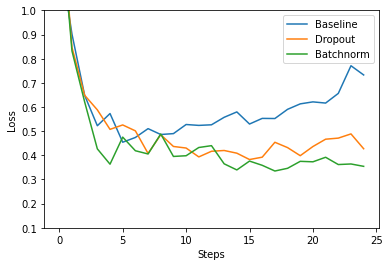

In [22]:
plot_loss(reg_results, loss = 'val_loss', ylim=(0.1, 1))

## Exercise: parameter tunning

We've introduced multiple regularization and optimization techniques to improve your model. How can you combine these techniques and perform grid search to find out a set of parameters that maximize your model performance on validation set? Are there other model architectures you'd like to try?